#### leer este paper https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6119093/

Elevated expression includes three subcategory types of elevated expression:

Tissue enriched: At least four-fold higher mRNA level in a particular tissue compared to any other tissue.
Group enriched: At least four-fold higher average mRNA level in a group of 2-5 tissues compared to any other tissue.
Tissue enhanced: At least four-fold higher mRNA level in a particular tissue compared to the average level in all other tissues.

https://www.biorxiv.org/content/10.1101/2021.05.12.443911v2.full.pdf
https://www.nature.com/articles/nn.4171

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import abagen
import json
import nibabel as nib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from src.ni_functions import *
from src.tree_functions import *
import pandas as pd
from glob import glob
from scipy.stats import zscore

/usr/local/lib/python3.9/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


In [2]:
project_path = "/workspaces/bha2"
conn_size = 2165

In [3]:
opt_gamma = 0.7
lvl = 28

tree = json.loads(
    open(
        os.path.join(
            project_path,
            "data",
            "results",
            "n" + str(conn_size),
            "tree_g_" + str(opt_gamma) + ".json",
        )
    ).read()
)
level, labels = level_from_tree(tree, lvl)

In [4]:
roi_heights = nib.load(os.path.join(
        project_path,
        "data",
        "results",
        "n" + str(conn_size),
        "roi_breaks_heights.nii.gz",
    )).get_fdata()
atlas = nib.load(os.path.join(
        project_path,
        "data",
        "results",
        "n" + str(conn_size),
        "initial_partition.nii.gz",
    ))

In [5]:
parcellation4allen = np.zeros((atlas.get_fdata().shape[0], atlas.get_fdata().shape[1], atlas.get_fdata().shape[2]))

module_median_heights = []
idx = 1
for rois in level:
    if(len(rois)>5):
        module_vol = get_module_vol(atlas, rois)
        parcellation4allen = parcellation4allen + (module_vol*idx).astype(int)
        idx += 1
nib.save(
    nib.Nifti1Image(parcellation4allen, affine=atlas.affine),
    os.path.join(
        project_path,
        "data",
        "results",
        "n" + str(conn_size),
        "parcellation4allen.nii.gz",
    )
)

In [6]:
# check if fcm and scm are stored in tmp folder
if os.path.exists(os.path.join(project_path, "tmp", "transcriptome_" + str(int(np.max(parcellation4allen))) + "modules.csv")):
    transcriptome = pd.read_csv(os.path.join(project_path, "tmp", "transcriptome_" + str(int(np.max(parcellation4allen))) + "modules.csv"), index_col=0)
    print("transcriptome loaded from tmp folder")
else:
    transcriptome = pd.DataFrame.transpose(abagen.get_expression_data(nib.Nifti1Image(parcellation4allen, affine=atlas.affine)))
    transcriptome.to_csv(os.path.join(project_path, "tmp", "transcriptome_" + str(int(np.max(parcellation4allen))) + "modules.csv"), index=True)

transcriptome loaded from tmp folder


<Axes: ylabel='gene_symbol'>

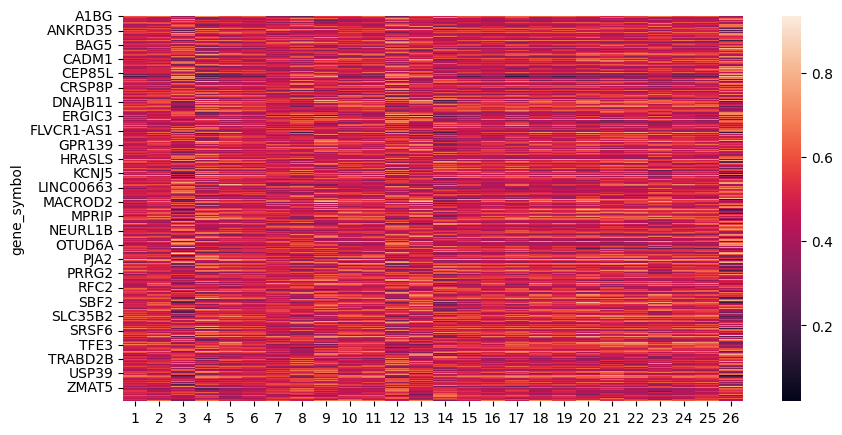

In [7]:
plt.rcParams['figure.figsize'] = [10, 5]
sns.heatmap(transcriptome)

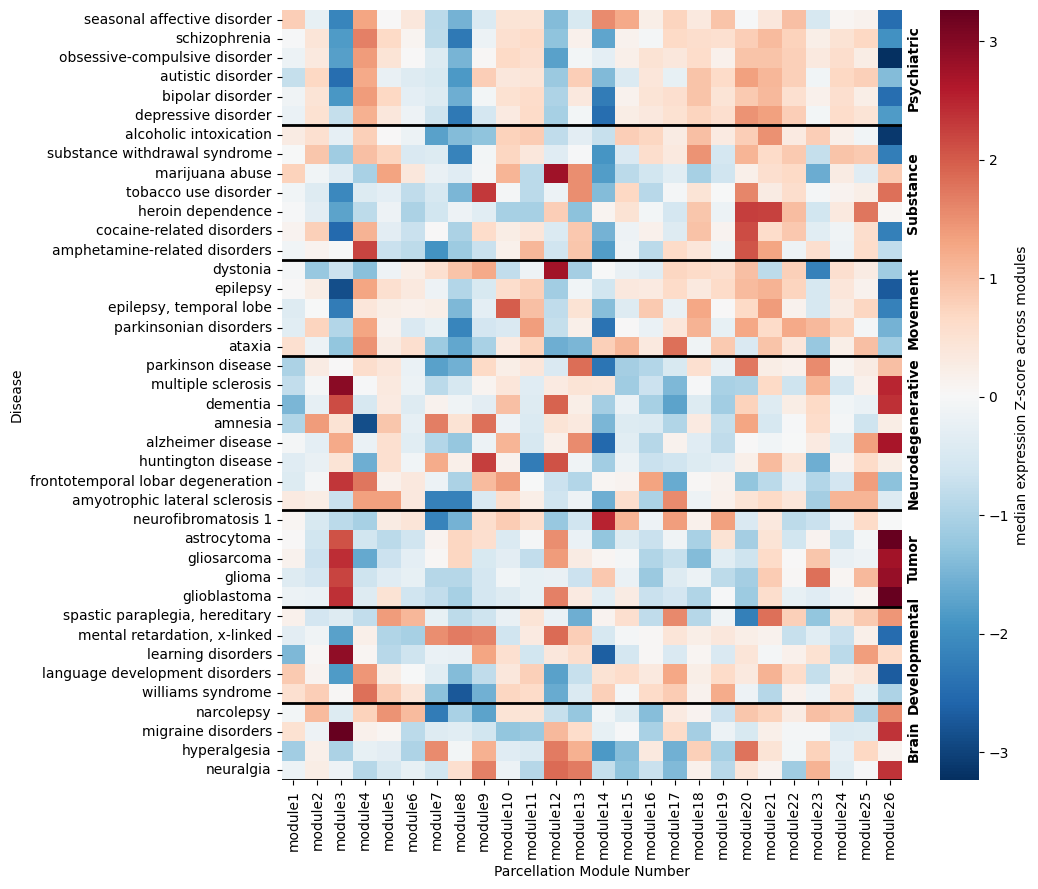

In [8]:
plt.rcParams['figure.figsize'] = [10, 10]

diseaseWHO_class = pd.read_csv(os.path.join(project_path, "data", "raw", "DiseaseWHOClass.csv"), index_col=0).sort_values(by=['Class'])
disease_name = diseaseWHO_class.index.values
WHOclass_names = ['Psychiatric', 'Substance',  'Movement', 'Neurodegenerative', 'Tumor', 'Developmental', 'Brain']
diseaseWHO_class["Class_name"] = diseaseWHO_class.Class.map({(i+1):WHOclass_names[i] for i in range(len(WHOclass_names))})


avg_exp_in_parcel = np.zeros((len(disease_name), transcriptome.shape[1]))
for idx_dis, dis in enumerate(disease_name):
    genes_in_dis = pd.read_csv(os.path.join(project_path, "data", "raw", "disease_genes", disease_name[idx_dis] + ".csv"), index_col=0)["x"].values
    transcriptome_in_dis = transcriptome.loc[transcriptome.index.isin(genes_in_dis), :]
    for m_parcel in range(transcriptome.shape[1]):
        avg_exp_in_parcel[idx_dis, m_parcel] = np.median(transcriptome_in_dis.iloc[:, m_parcel])
avg_exp_in_parcel_z = zscore(avg_exp_in_parcel, axis=1)
hmap = sns.heatmap(avg_exp_in_parcel_z, cmap="RdBu_r", cbar_kws={'label': 'median expression Z-score across modules'},
            yticklabels=disease_name, xticklabels=["module"+str(m_number + 1) for m_number in range(transcriptome.shape[1])])

line_offset = 0
for who_classes in range(np.min(diseaseWHO_class["Class"]), np.max(diseaseWHO_class["Class"])+1):
    n_diseases_in_class = len(diseaseWHO_class[diseaseWHO_class["Class"]==who_classes])
    line_offset += n_diseases_in_class
    text_offset = line_offset - n_diseases_in_class/2
    hmap.axhline(line_offset, color="black", linewidth=2)
    # add the name of the class at the right of the line
    hmap.text(transcriptome.shape[1]+0.5, text_offset, diseaseWHO_class[diseaseWHO_class["Class"]==who_classes]["Class_name"].values[0], fontsize=10, fontweight="bold", rotation=90, va="center", ha="center")


plt.xlabel("Parcellation Module Number")
plt.ylabel("Disease")

plt.savefig(
    os.path.join(project_path, "data", "results", "figures", "genetic_disorders.svg"),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)
